In [1]:
import numpy as np
import nnkcde
from cdetools.cde_loss import cde_loss
from matplotlib import pyplot as plt

In [5]:
!pip install /Users/arthurthomas/Documents/GitHub/NNKCDE/python

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Processing /Users/arthurthomas/Documents/GitHub/NNKCDE/python
Using legacy 'setup.py install' for nnkcde, since package 'wheel' is not installed.
  Attempting uninstall: nnkcde
    Found existing installation: nnkcde 0.3
    Uninstalling nnkcde-0.3:
      Successfully uninstalled nnkcde-0.3
    Running setup.py install for nnkcde ... done


In the following cell we run the `wget` module to fetch the data from the [COINtoolbox Github repository](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy). <br>
You can download the Teddy A and B manually if you prefer.

In [2]:
import os
import wget

data_dir = 'data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print('"data" subfolder created')
    
_ = wget.download('https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_A', 
              out='data/teddy_A.txt')

_ = wget.download('https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_B', 
              out='data/teddy_B.txt')

The following lines assume you have the datasets `Teddy A` and `Teddy B` in a subfolder of your current directory. By default this subfolder is `data`, but it can be changed below. The following function extract the information from the .txt file and generates numpy array. <br> <br>

You can find the `Teddy A` and `Teddy B` dataset in the [COINtoolbox Github repository](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy).

In [3]:
def extract_teddy_data(filename, train_data, directory='data/'):
    
    full_data = []
    outfiles = ('teddy_x_train.npy', 'teddy_z_train.npy') if train_data else ('teddy_x_test.npy', 'teddy_z_test.npy')
    with open(filename) as fp:
        full_lines = fp.readlines()
        for line in full_lines:
            if '#' in line:
                continue
            full_data.append([float(el) for el in line.strip().split(' ') if el])
        fp.close()
    
    # Saving the formatted Teddy data
    np.save(arr=np.array(full_data)[:, 7:12], file=directory + outfiles[0])
    np.save(arr=np.array(full_data)[:, 6], file=directory + outfiles[1])
    print('Extraction and Saving Done!')

In [4]:
extract_teddy_data(filename='data/teddy_A.txt', train_data=True, directory='data/')

Extraction and Saving Done!


In [5]:
extract_teddy_data(filename='data/teddy_B.txt', train_data=False, directory='data/')

Extraction and Saving Done!


## Load Teddy Cosmology Data

The $\texttt{TEDDY}$ data are comprised of 4 datasets, generated by subsampling from the [SDSS DR12](https://www.sdss.org/dr12/). <br>
The 4 datasets are named respectively A, B, C and D.

We use dataset A for training and B for testing.<br>
Data in these two datasets share the same underlying distribution, so training-based algorithms do not need any further adjustments. <br>
For more information, consult the [TEDDY Github Repo](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy).

Both datasets have around 74,000 spectroscopic samples in it. <br>
We downsample both training and testing, including only the first 2,000 and 500 galaxies respectively.

In [8]:
train_limit_points = 2000    # Limiting the training set
test_limit_points = 500      # Limiting the test set

x_train = np.load(file='data/teddy_x_train.npy')[:train_limit_points, :]
x_test = np.load(file='data/teddy_x_test.npy')[:test_limit_points, :]
z_train = np.load(file='data/teddy_z_train.npy')[:train_limit_points]
z_test = np.load(file='data/teddy_z_test.npy')[:test_limit_points]

array([[-0.001069,  0.205242,  0.123685, -0.623802, -0.354959],
       [ 0.283997, -0.26265 ,  0.449938, -0.441687,  0.242252],
       [ 0.575361, -0.720166,  0.845885, -0.041332,  0.063122],
       ...,
       [ 0.169917, -0.699744,  0.96067 , -0.34241 , -0.216449],
       [ 0.298833, -0.453464,  0.940948, -0.178197, -0.100028],
       [ 0.640442,  0.208727,  0.365337,  0.234866,  0.122811]])

Loading dataset

## Running NNKCDE

As any $\texttt{sklearn}$ model, with the first call we initialize the model. <br>
Here we specify the number of neighbors $k$ (but we could also specify that in the prediction phase).

In [7]:
k = 50
from nnkcde.core import NNKCDE
model = NNKCDE(k=k)

We then train the model by using the `fit` method

In [16]:
model.fit(x_train, z_train)

For prediction, we need to specify:
* the CDE support, i.e. the grid over which we want the CDE to be predicted. Here we use the training data to inform the redshift minimum and maximum, and generate `n_grid` linearly separated values between the two.
* the bandwith of the KDE with `bandwidth`

In [9]:
n_grid = 1000
bandwidth = 0.01
z_grid = np.linspace(z_train.min(), z_train.max(), n_grid)

cde_test = model.predict(x_test, z_grid, bandwidth=bandwidth)

The output CDEs are `n_grid` dimensional densities, stored  in a numpy array. <br>
They are proper density, i.e. they integrate to 1.

In [10]:
from scipy.integrate import simps

print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

(<type 'numpy.ndarray'>, (500, 1000))
Integral of the first density integrates to: 1.00


Scalability is improved because of how the NN search tree is built on the backend as well as the KDE convolution shortcut!

### Visualize the conditional density estimates

We here visualize the first 12 CDEs

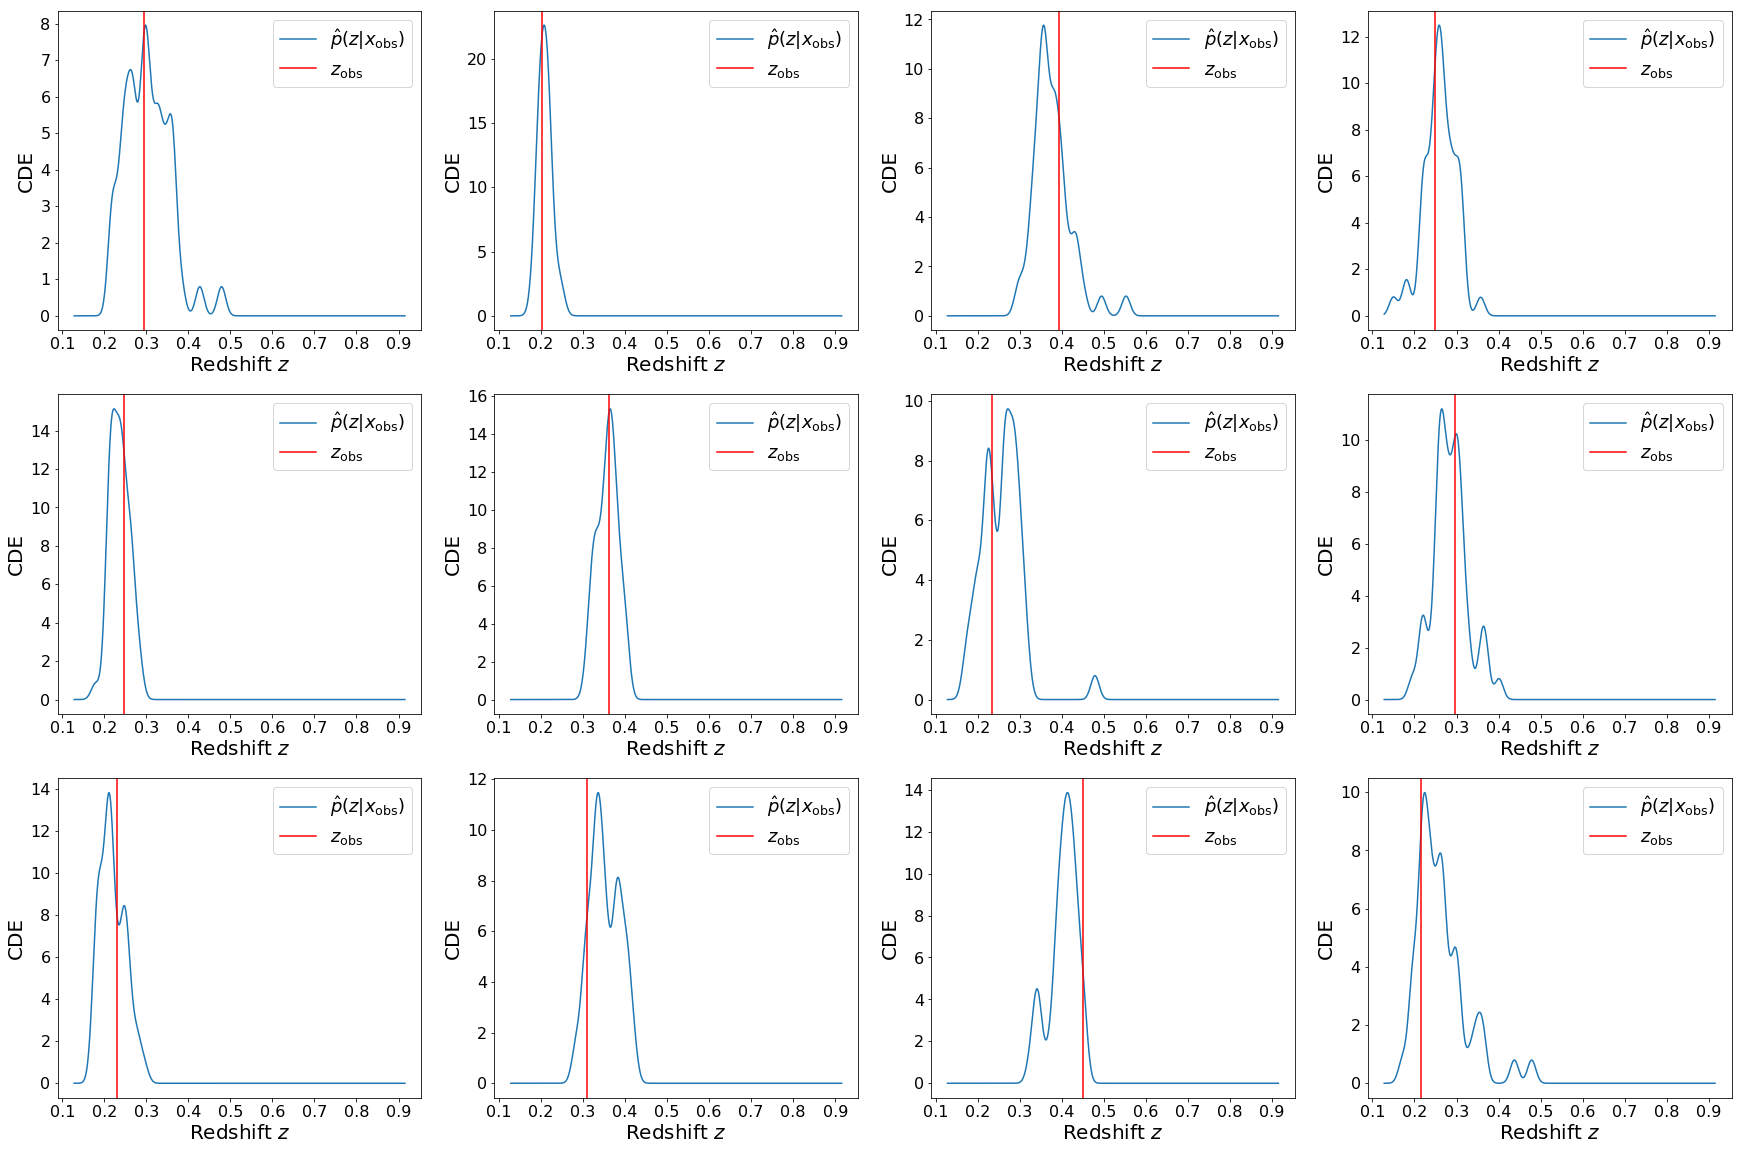

In [11]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.axvline(z_test[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 18})
plt.show()

## Select the best parameters combination

We can use the CDE loss to guide us (the lower, the better), from the [`cdetools` package](https://github.com/tpospisi/cdetools). <br>
Here we showcase a simple grid search approach, but one can use random search or more advanced methods such as [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization).

In [12]:
h_search_vec = [1e-2, 5e-2, 0.1]
neigh_search_vec = [10, 20, 50, 100]

results_search = {}
for h in h_search_vec:
    for neigh in neigh_search_vec:
        cde_test_temp = model.predict(x_test, z_grid, k=neigh, bandwidth=h)
        cde_loss_temp, std_loss_temp = cde_loss(cde_test_temp, z_grid, z_test)
        message_out = r'Bandwith: %.2f, Neighbors: %d, CDE loss: %4.2f \pm %.2f' % (
            h, neigh, cde_loss_temp, std_loss_temp)
        results_search[(h, neigh)] = (cde_loss_temp, std_loss_temp)
        print(message_out)
        
best_combination = sorted(results_search.items(), key=lambda x: x[1][0])[0]
print('\nBest CDE loss (%4.2f) is achieved using %d Neighbors and KDE bandwidth=%.2f' % (
      best_combination[1][0], best_combination[0][1], best_combination[0][0]))

Bandwith: 0.01, Neighbors: 10, CDE loss: -10.83 \pm 0.58
Bandwith: 0.01, Neighbors: 20, CDE loss: -11.42 \pm 0.49
Bandwith: 0.01, Neighbors: 50, CDE loss: -11.92 \pm 0.41
Bandwith: 0.01, Neighbors: 100, CDE loss: -11.32 \pm 0.35
Bandwith: 0.05, Neighbors: 10, CDE loss: -7.74 \pm 0.11
Bandwith: 0.05, Neighbors: 20, CDE loss: -7.72 \pm 0.10
Bandwith: 0.05, Neighbors: 50, CDE loss: -7.65 \pm 0.10
Bandwith: 0.05, Neighbors: 100, CDE loss: -7.49 \pm 0.10
Bandwith: 0.10, Neighbors: 10, CDE loss: -4.77 \pm 0.03
Bandwith: 0.10, Neighbors: 20, CDE loss: -4.76 \pm 0.03
Bandwith: 0.10, Neighbors: 50, CDE loss: -4.74 \pm 0.03
Bandwith: 0.10, Neighbors: 100, CDE loss: -4.70 \pm 0.03

Best CDE loss (-11.92) is achieved using 50 Neighbors and KDE bandwidth=0.01


## CDE Diagnostics

We can compute the PIT and HPD values over our estimated CDEs. <br>
Functions to calculate both values can be found in the [`cdetools` package](https://github.com/tpospisi/cdetools). <br>
We suggest to clone the Github repository and install it.

<code style="background:black;color:white">git clone https://github.com/tpospisi/cdetools.git </code> <br>
<code style="background:black;color:white">cd cdetools/python/ </code> <br>
<code style="background:black;color:white">python setup.py install </code> 

In [13]:
from cdetools.hpd_coverage import hpd_coverage
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band

# Computing the values
z_grid = np.linspace(z_train.min(), z_train.max(), n_grid)
pit_values = cdf_coverage(cde_test, z_grid, z_test)
hpd_values = hpd_coverage(cde_test, z_grid, z_test)

Computing the number of values per each bin in the histogram under uniformity assumptions. <br>
We look at the 99% CI.

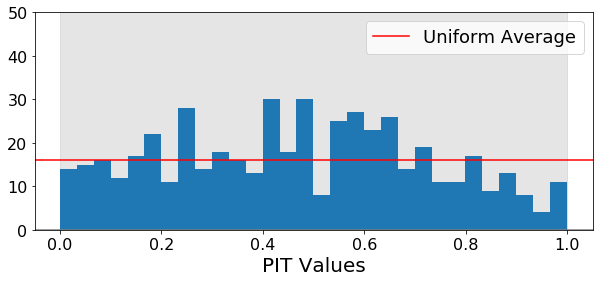

In [14]:
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.99, x_label='PIT Values', n_bins=30)
fig_pit

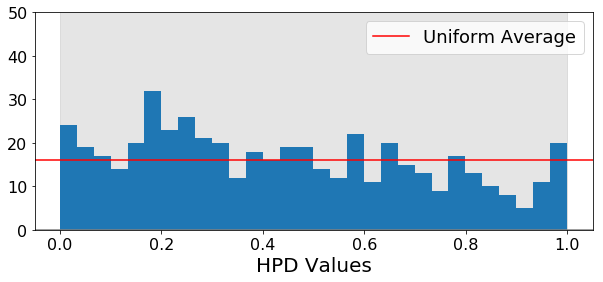

In [15]:
fig_hpd = plot_with_uniform_band(values=hpd_values, ci_level=0.99, x_label='HPD Values', n_bins=30)   
fig_hpd